# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [211]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

import category_encoders as ce
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
from sklearn import 
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [212]:
churn_data_orig = pd.read_csv('C:/Users/atade/OneDrive/Рабочий стол/Learning/Machine_Learning/HW_ML_3/churn.csv')


churn_data = churn_data_orig.copy()

## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [213]:

churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [214]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [215]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [216]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [217]:
churn_data[churn_data.duplicated()].sum()

data = churn_data.copy()

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

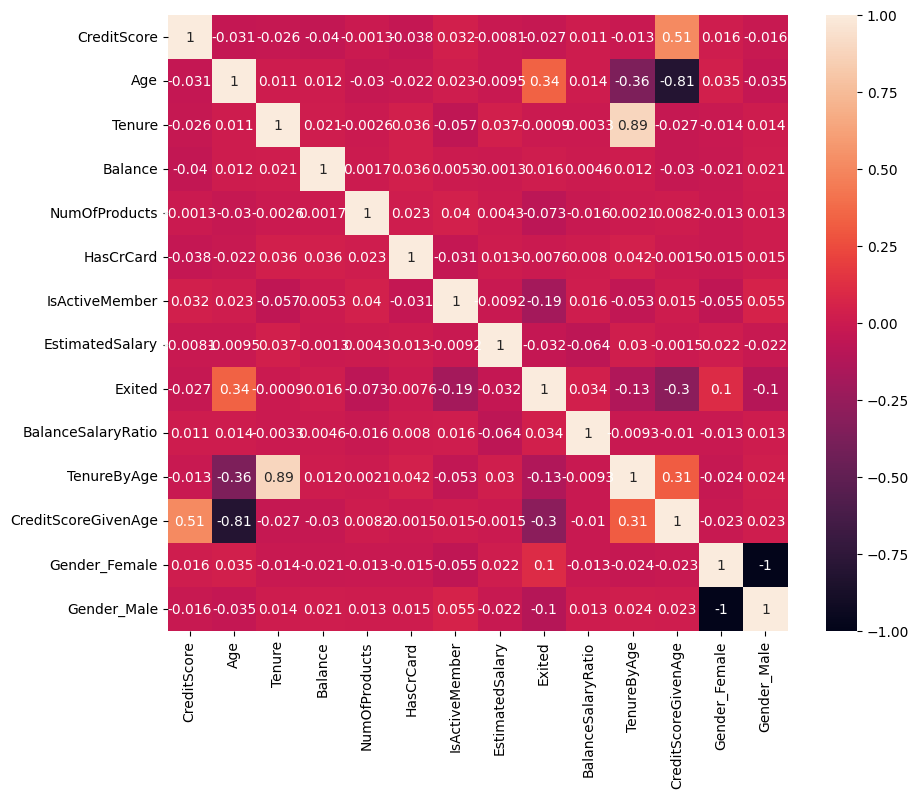

'BalanceSalaryRatio'

count     2509.000000
mean         9.024870
std        214.286020
min          0.192582
25%          0.783284
50%          1.197220
75%          2.400083
max      10614.655440
Name: BalanceSalaryRatio, dtype: float64

'TenureByAge'

count    2509.000000
mean        0.134303
std         0.087680
min         0.000000
25%         0.060606
50%         0.125000
75%         0.200000
max         0.500000
Name: TenureByAge, dtype: float64

'CreditScoreGivenAge'

count    2509.000000
mean       17.526487
std         5.349558
min         6.112676
25%        13.686275
50%        16.857143
75%        20.852941
max        46.388889
Name: CreditScoreGivenAge, dtype: float64

In [218]:
data['BalanceSalaryRatio'] = data['Balance']/data['EstimatedSalary']
data['TenureByAge'] = data['Tenure']/data['Age']
data['CreditScoreGivenAge'] = data['CreditScore']/data['Age']

data = pd.get_dummies(data=data, columns=['Gender'])

fig = plt.figure(figsize=(10,8))
sns.heatmap(data=data.corr(), annot=True)
plt.show()
display('BalanceSalaryRatio', data['BalanceSalaryRatio'].describe())
display('TenureByAge', data['TenureByAge'].describe())
display('CreditScoreGivenAge',data['CreditScoreGivenAge'].describe())


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [219]:
X = data.drop("Exited", axis=1)
y = data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [220]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [221]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 13)
Test shape: (628, 13)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [222]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [223]:
len(data.columns[4])

13

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


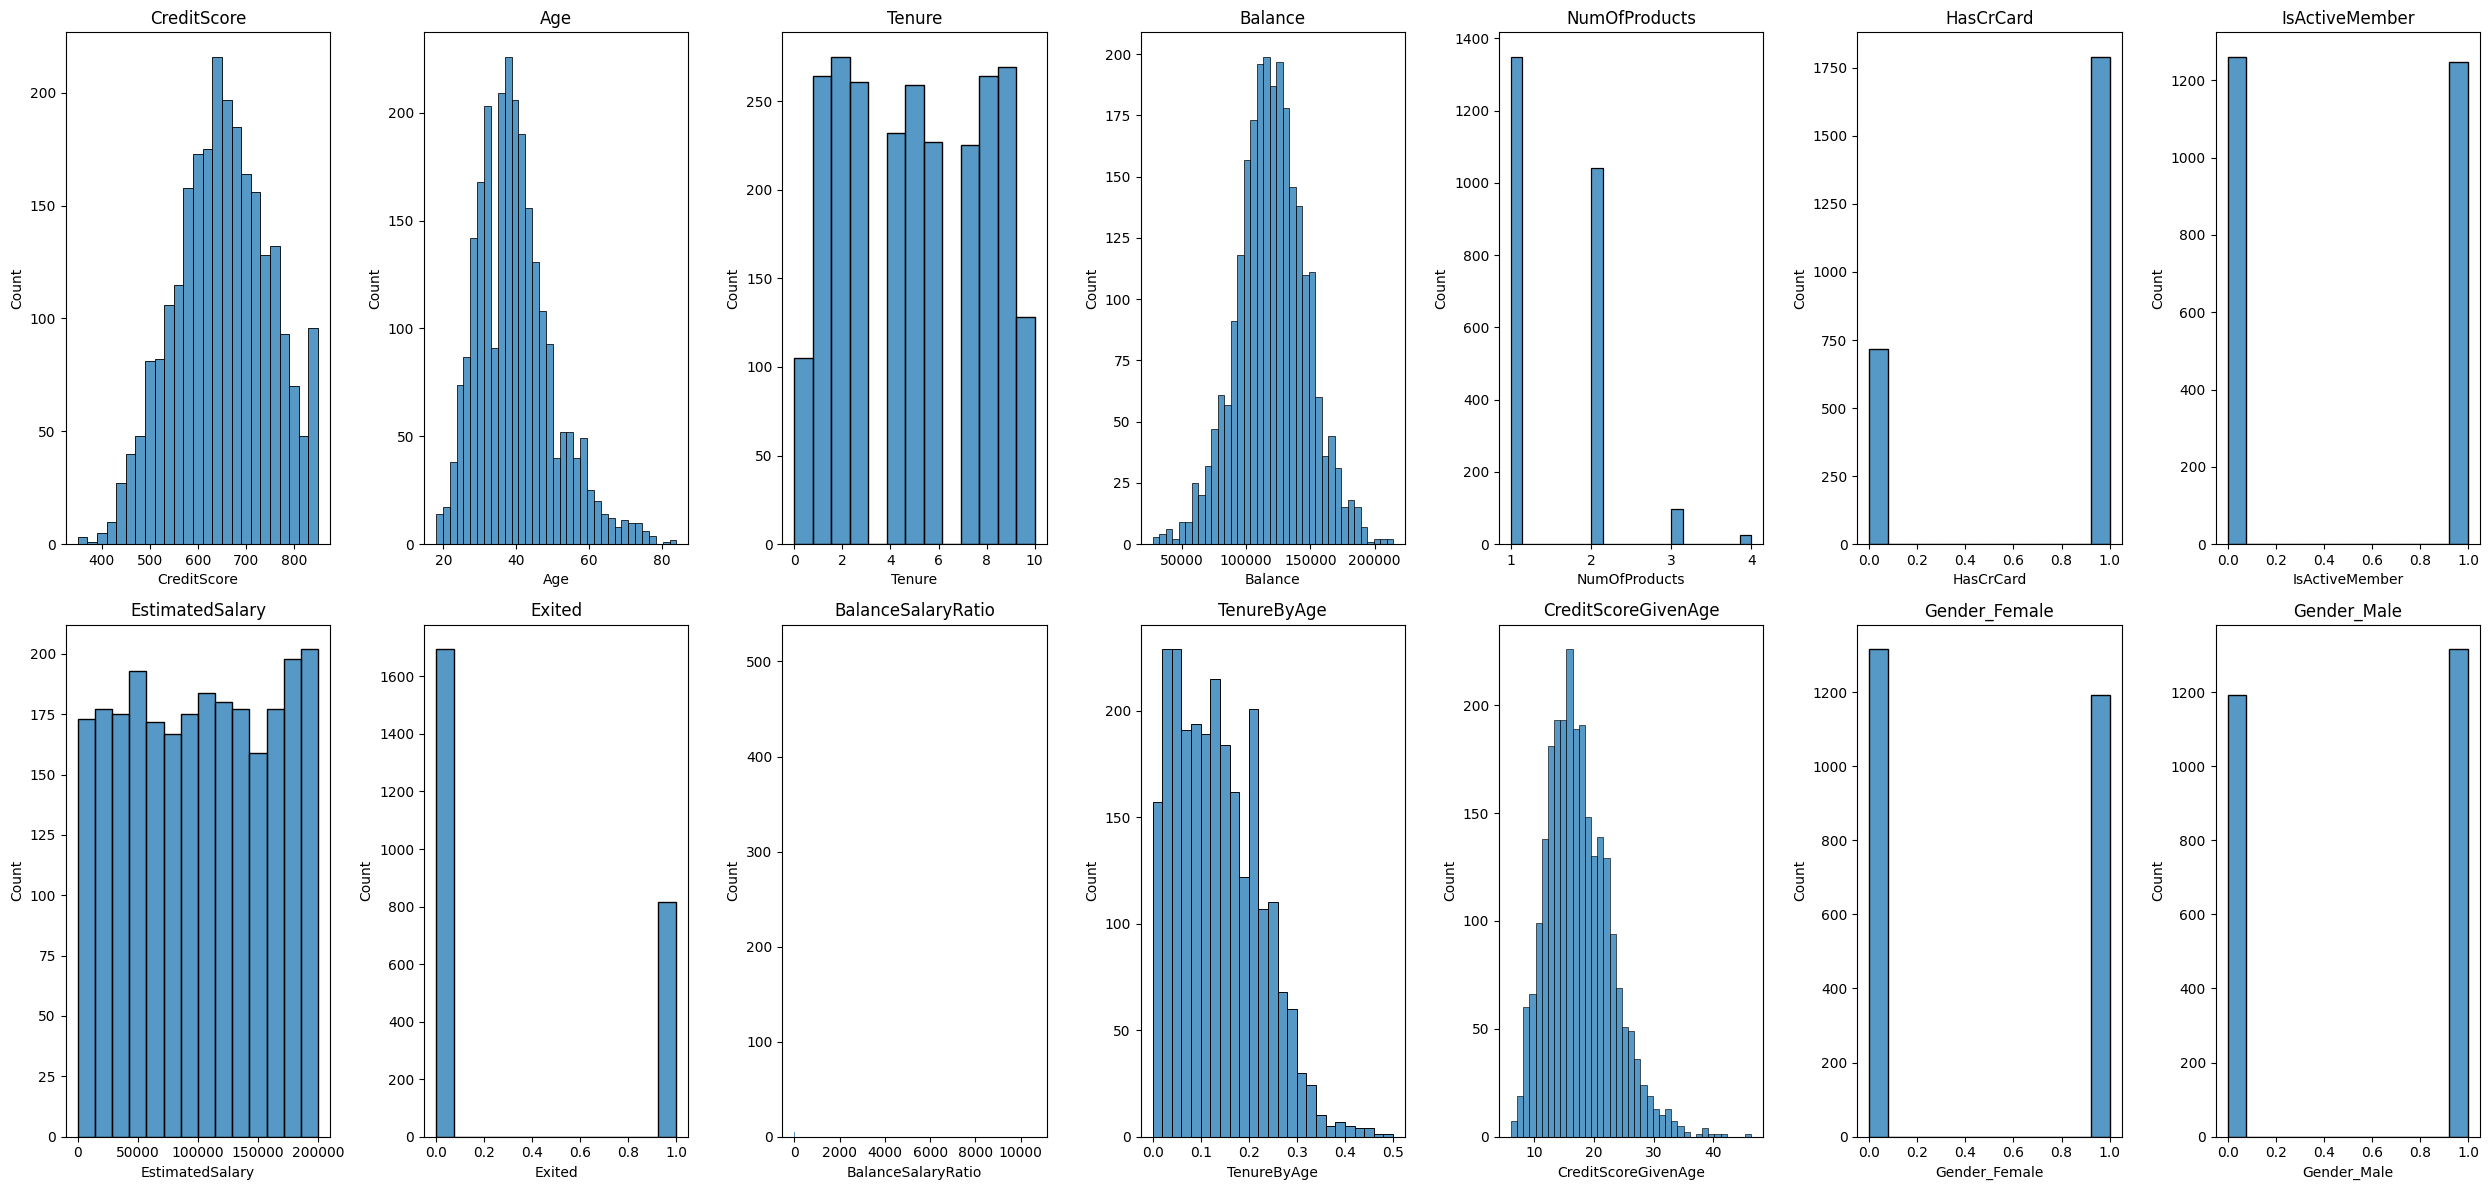

In [224]:
fig, ax = plt.subplots(2, len(data.columns)//2, figsize=(25,12) )
    
for i in range(0, len(data.columns)):
    if i < len(data.columns)//2:
        histplot = sns.histplot(data=data, x = data.columns[i], ax=ax[0][i])
        histplot.set_title(f'{data.columns[i]}')
    else:
        histplot = sns.histplot(data=data, x = data.columns[i], ax=ax[1][abs(i - len(data.columns)//2)])
        histplot.set_title(f'{data.columns[i]}')
    plt.tight_layout()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


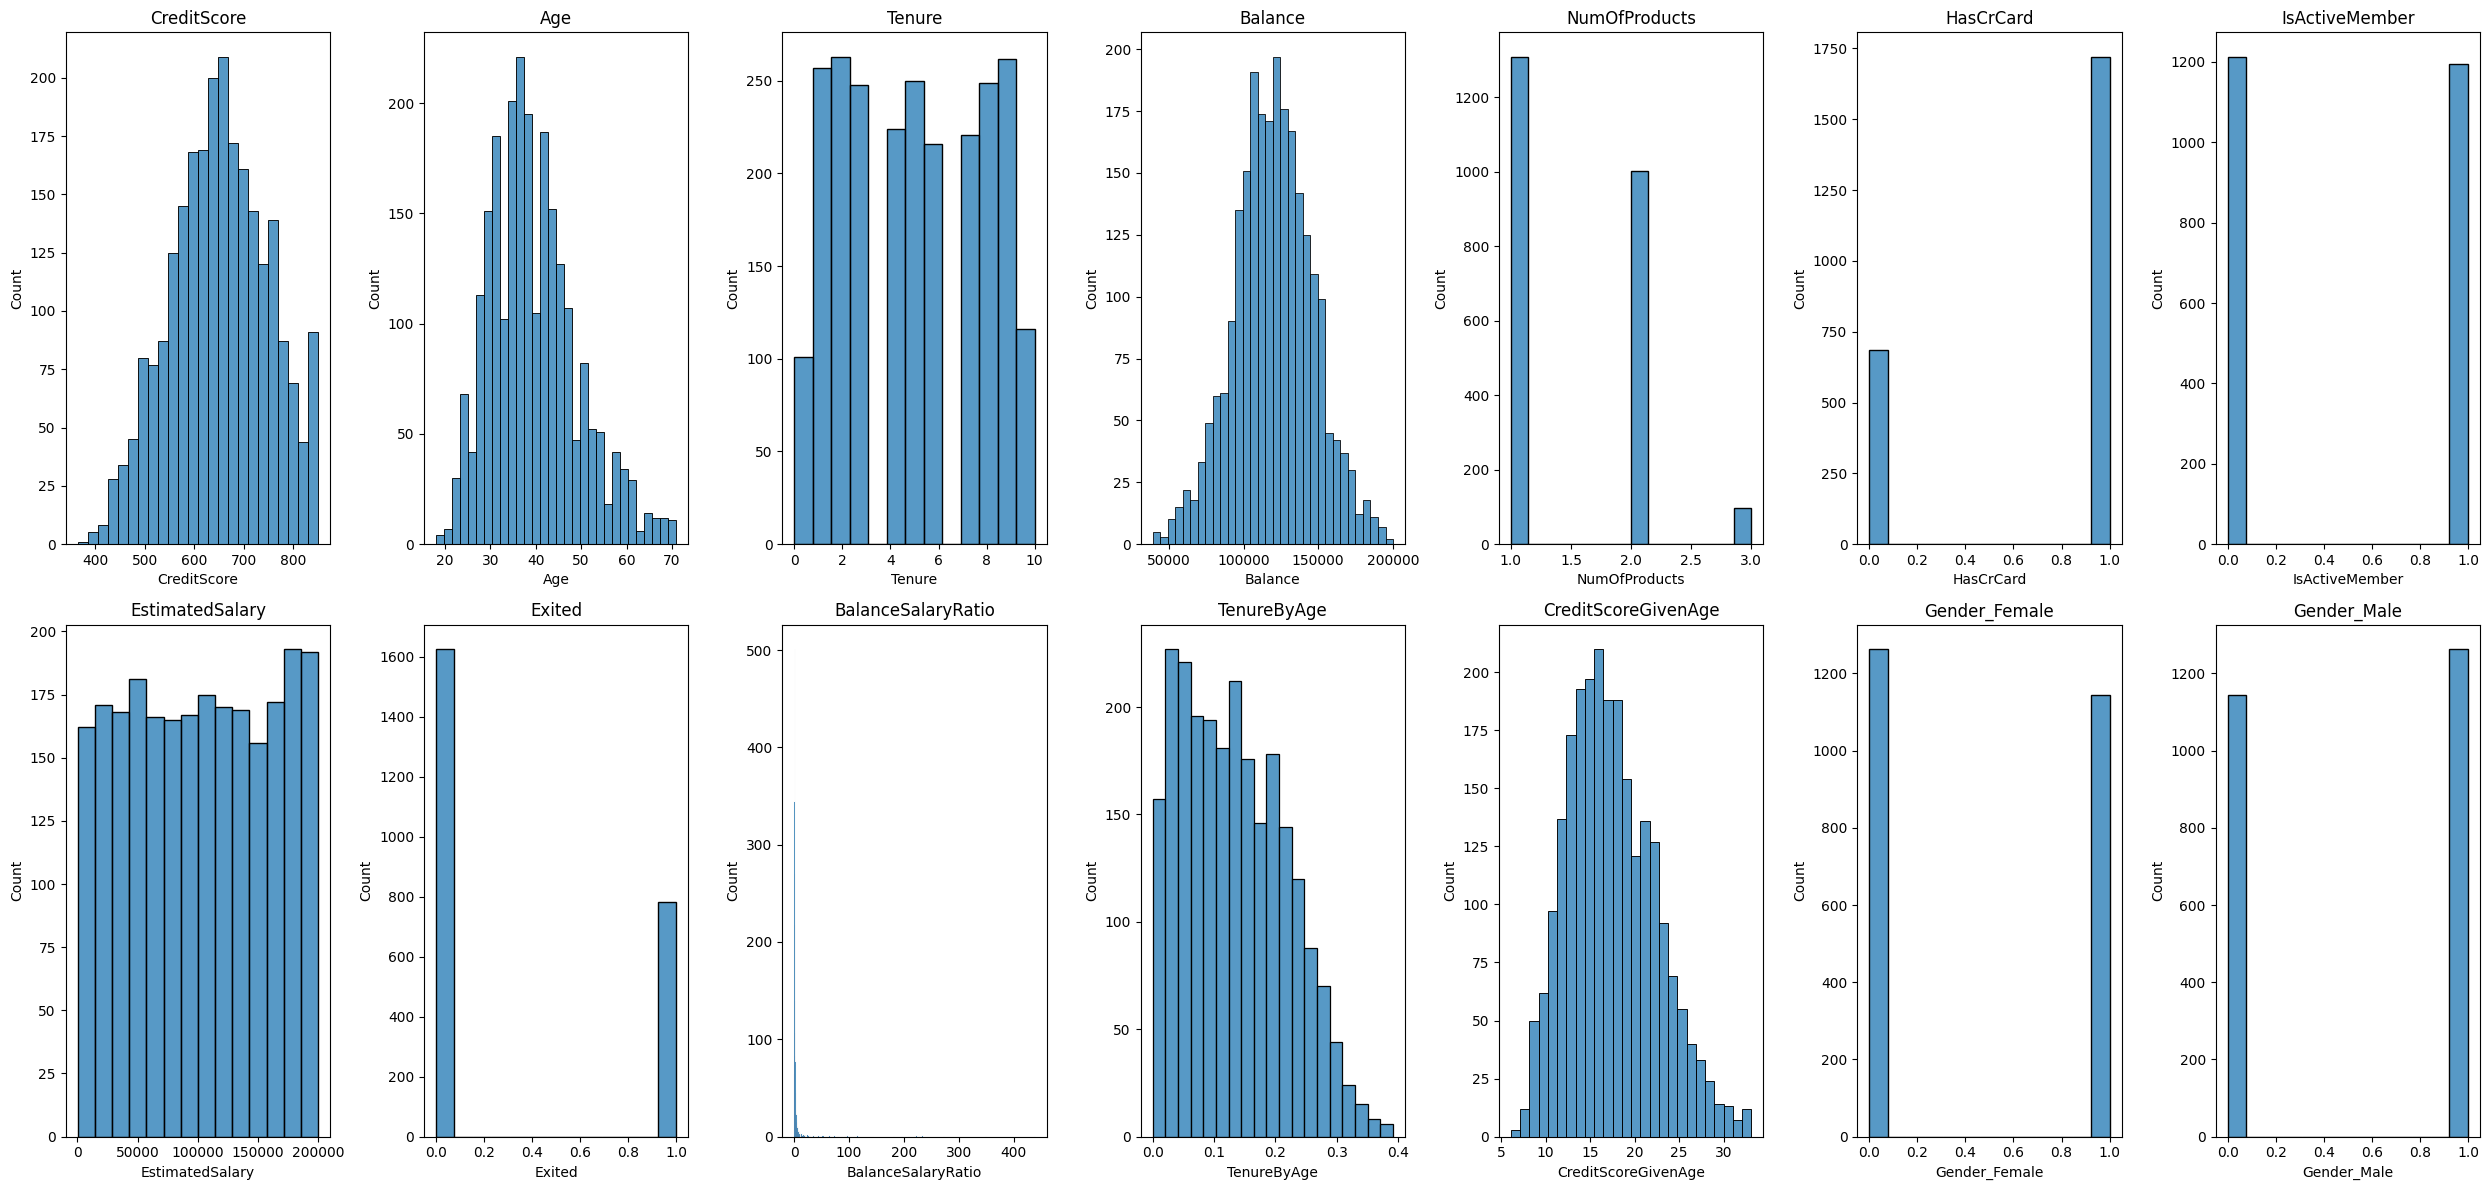

In [225]:
def sigma_3(df, col, emiss=False, left_s=3, right_s=3):

    sigma = df[col].std()
    mu = df[col].mean()
    form_min = mu - left_s*sigma
    form_max = mu + right_s*sigma

    sorted_df = df[(df[col] < form_max) & (df[col] > form_min)]
    emission_list = df[(df[col] >= form_max) | (df[col] <= form_min)][col].values
    if emiss:
        return sorted_df, emission_list
    return sorted_df

data_new = data.copy()

for i in data.columns:
    data_new = sigma_3(data_new, i)

fig, ax = plt.subplots(2, len(data.columns)//2, figsize=(25,12) )
    
for i in range(0, len(data.columns)):
    if i < len(data.columns)//2:
        histplot = sns.histplot(data=data_new, x = data.columns[i], ax=ax[0][i])
        histplot.set_title(f'{data.columns[i]}')
    else:
        histplot = sns.histplot(data=data_new, x = data.columns[i], ax=ax[1][abs(i - len(data.columns)//2)])
        histplot.set_title(f'{data.columns[i]}')
    plt.tight_layout()

In [226]:
data.shape[0] - data_new.shape[0]

102

In [245]:
minmax = preprocessing.MinMaxScaler()

minmax = minmax.fit(X_train)

X_train_scaled =  minmax.transform(X_train)

X_test_scaled = minmax.transform(X_test)

In [269]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=data.drop(columns='Exited').columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=data.drop(columns='Exited').columns)

In [248]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          1881 non-null   float64
 1   Age                  1881 non-null   float64
 2   Tenure               1881 non-null   float64
 3   Balance              1881 non-null   float64
 4   NumOfProducts        1881 non-null   float64
 5   HasCrCard            1881 non-null   float64
 6   IsActiveMember       1881 non-null   float64
 7   EstimatedSalary      1881 non-null   float64
 8   BalanceSalaryRatio   1881 non-null   float64
 9   TenureByAge          1881 non-null   float64
 10  CreditScoreGivenAge  1881 non-null   float64
 11  Gender_Female        1881 non-null   float64
 12  Gender_Male          1881 non-null   float64
dtypes: float64(13)
memory usage: 191.2 KB


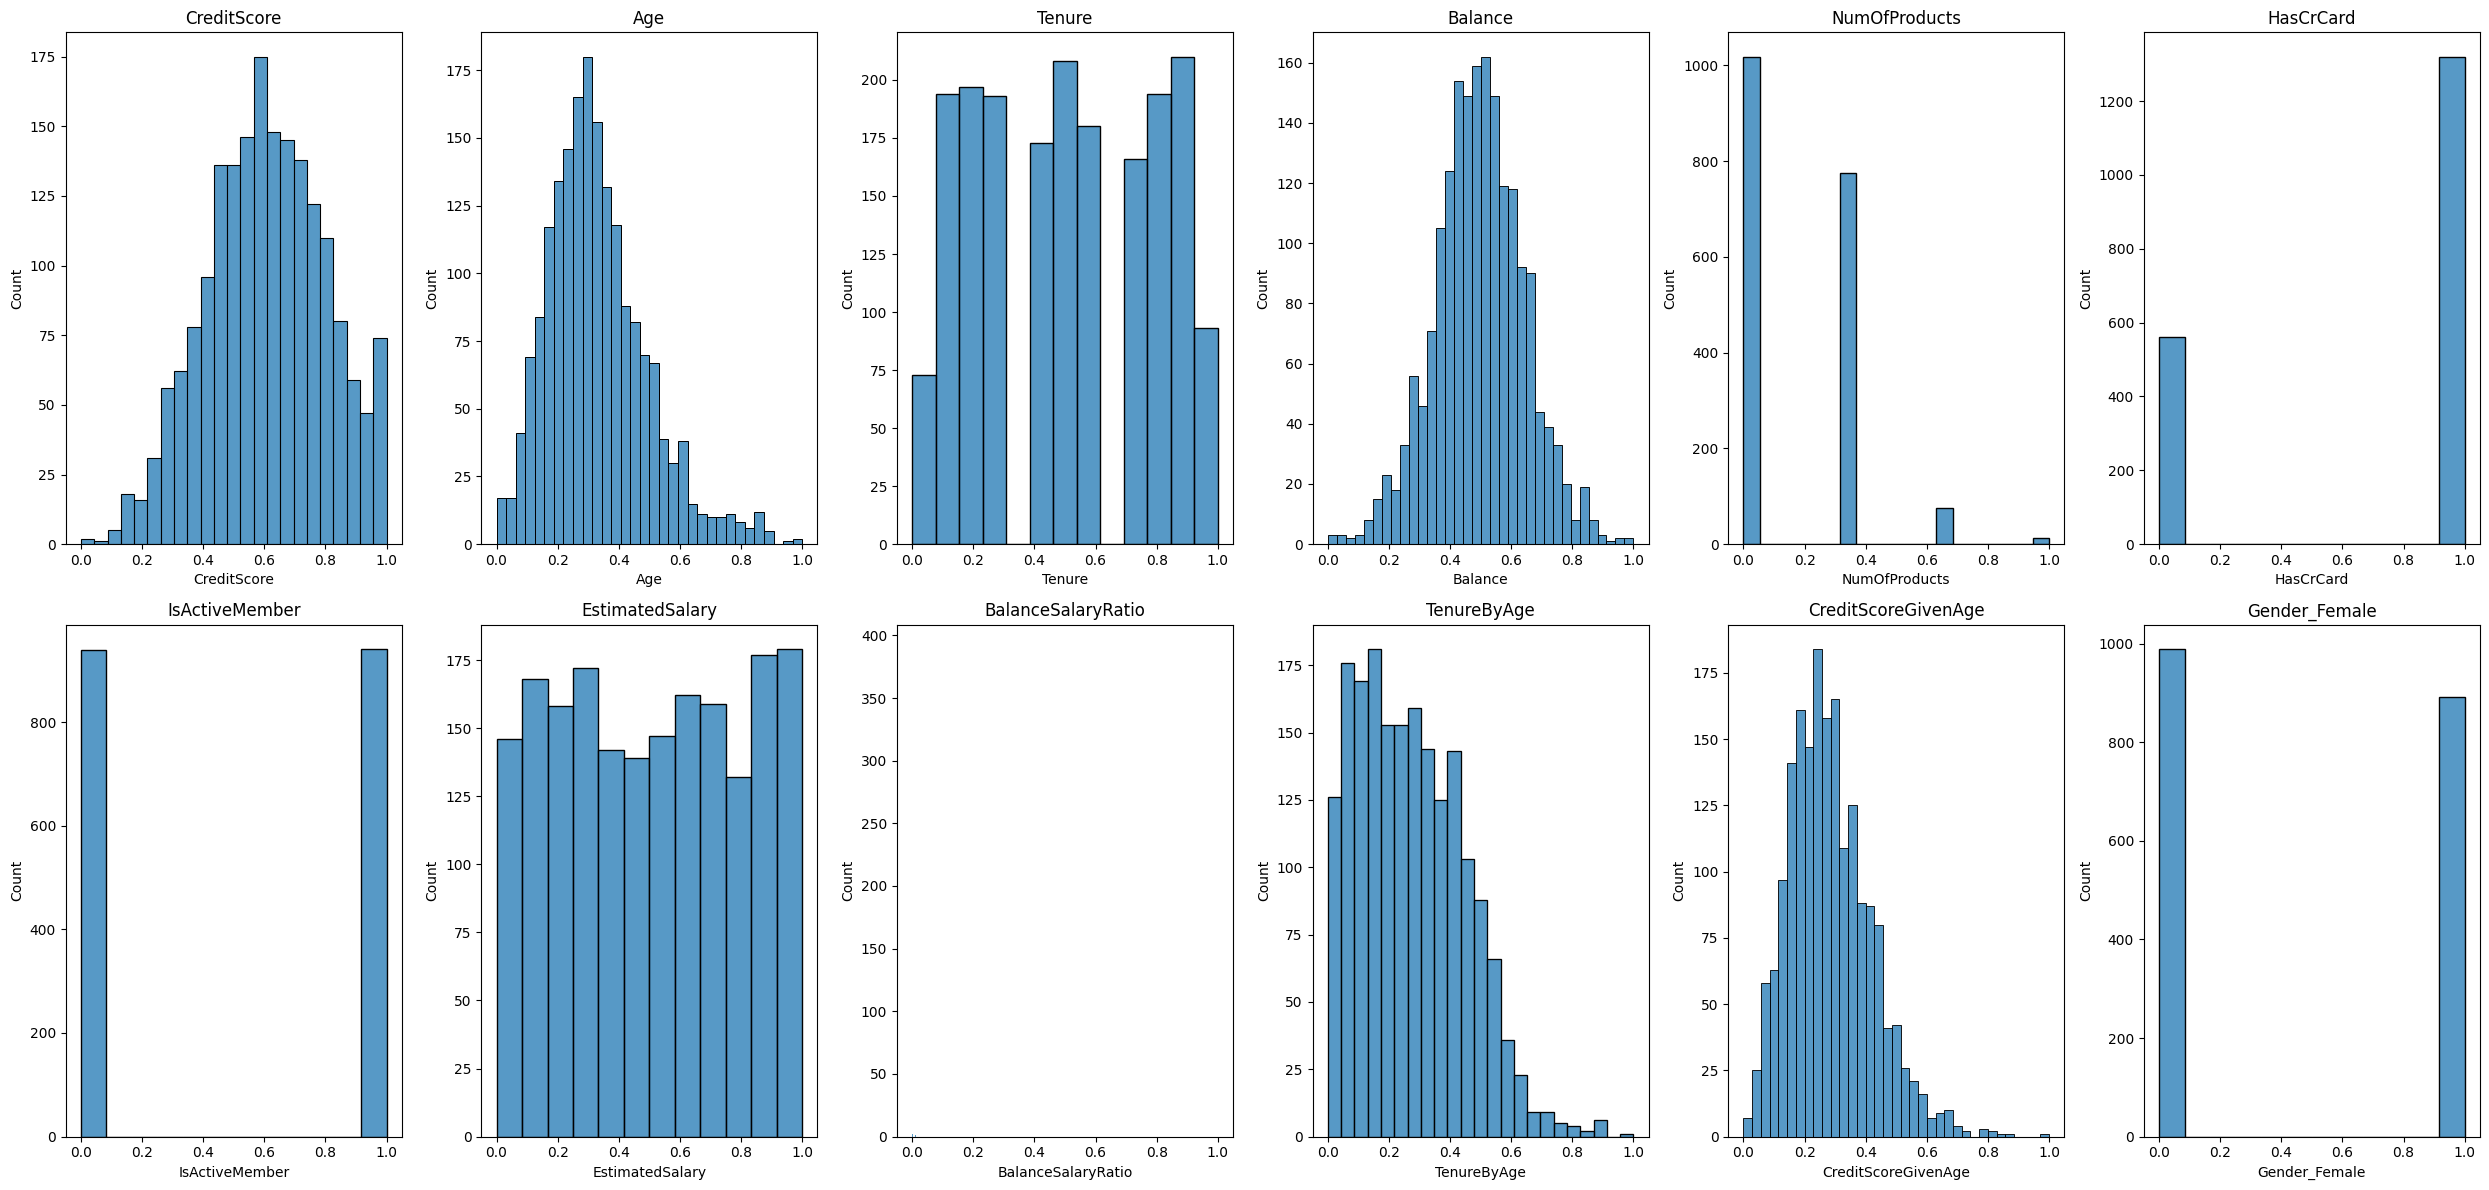

In [256]:
fig, ax = plt.subplots(2, len(X_train_scaled.columns)//2, figsize=(25,12) )
    
for i in range(0, len(X.columns) -1):
    if i < len(X_train_scaled.columns)//2:
        histplot = sns.histplot(data=X_train_scaled, x = X_train_scaled.columns[i], ax=ax[0][i])
        histplot.set_title(f'{X_train_scaled.columns[i]}')
    else:
        histplot = sns.histplot(data=X_train_scaled, x = X_train_scaled.columns[i], ax=ax[1][abs(i - len(X_train_scaled.columns)//2)])
        histplot.set_title(f'{X_train_scaled.columns[i]}')
    plt.tight_layout()

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Укажите название метрики и обоснования своего выбора здесь

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> F1_score / precision&recall - пройдемся по всем пунктам:
1. Accuracy - в нашем случае не подходящий вариант, поскольку мы не используем bootstrap в логистист. регрессии, следовательно не можем увеличить выборку потенциально ушедших клиентов, а их значительно меньше, чем лояльных. Если выборки не пропорциональны то метод accuracy не самый подходящий вариант. 
2. Precision - не подходит поскольку нас интреусует удержание как можно большего количества нелояльных клиентов. Precision покажет как много мы ошибаемся в выборе нелояльных клиентов, однако не покажет сколько их не было учтено в принципе. В то же время, если ориентироваться на заключительную фразу задания: "Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели", то можно воспользоваться и precision для выполнения первой части , однако я бы предпочел F1
3. Recall - схожая проблема с precision - не отвечает нашим требованиям только с другой стороны. Покажет сколько из общей выборки нелояльных клиентов мы идентифицировали, как нелояльных, но не покажет сколько ошибок при это допущено. Можем взять всю выборку, как нелояльных клеинтов и recall будет 100% - не подходит.
4. F1-score - самый оптимальный вариант в нашем случае, поскольку показываает среднее между recall и precision.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [270]:
logistic = linear_model.LogisticRegression(random_state=42)

model = logistic.fit(X=X_train_scaled, y=y_train)

y_test_pred = model.predict(X=X_test_scaled)
y_train_pred = model.predict(X=X_train_scaled)

print('TEST', '\n', metrics.classification_report(y_pred=y_test_pred, y_true=y_test))

print('TRAIN', '\n', metrics.classification_report(y_pred=y_train_pred, y_true=y_train))

TEST 
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.62      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.68      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628

TRAIN 
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881



In [271]:
logistic = linear_model.LogisticRegression(random_state=42, penalty='l2', C=10)

model = logistic.fit(X=X_train_scaled, y=y_train)

y_test_pred = model.predict(X=X_test_scaled)
y_train_pred = model.predict(X=X_train_scaled)

print('TEST', '\n', metrics.classification_report(y_pred=y_test_pred, y_true=y_test))

print('TRAIN', '\n', metrics.classification_report(y_pred=y_train_pred, y_true=y_train))

TEST 
               precision    recall  f1-score   support

           0       0.75      0.86      0.81       424
           1       0.59      0.42      0.49       204

    accuracy                           0.72       628
   macro avg       0.67      0.64      0.65       628
weighted avg       0.70      0.72      0.70       628

TRAIN 
               precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.43      0.51       610

    accuracy                           0.73      1881
   macro avg       0.70      0.66      0.67      1881
weighted avg       0.72      0.73      0.72      1881



Наше целевое значение - это 1, поскольку она означает ушедших клиентов. И, к сожалению, предугадывание именно этого класса у модели получается значительно хуже, чем другого. Модель явно является недообученой поскольку, метрика (даже после уменьшения коэфициента регуляризации) показывает значения ниже, чем 0.5, а это значит, что подбраюсывание монеты в теории лучше бы справилось с этой задачей. Недообучение резонно, ведь мы используем примитивную логистическую регрессиию, наша модель не достаточно "умна", чтобы найти сложные взаимосвязи. 

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [272]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

polyer = poly.fit(X=X_train_scaled)

X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

logistic_poly = linear_model.LogisticRegression(random_state=42)

model_poly = logistic_poly.fit(X=X_train_scaled_poly, y=y_train)

y_train_pred = model_poly.predict(X=X_train_scaled_poly)
y_test_pred = model_poly.predict(X=X_test_scaled_poly)

print('TEST', '\n', metrics.classification_report(y_pred=y_test_pred, y_true=y_test))

print('TRAIN', '\n', metrics.classification_report(y_pred=y_train_pred, y_true=y_train))

TEST 
               precision    recall  f1-score   support

           0       0.81      0.90      0.86       424
           1       0.74      0.57      0.64       204

    accuracy                           0.79       628
   macro avg       0.78      0.74      0.75       628
weighted avg       0.79      0.79      0.79       628

TRAIN 
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1271
           1       0.77      0.58      0.66       610

    accuracy                           0.81      1881
   macro avg       0.80      0.75      0.76      1881
weighted avg       0.80      0.81      0.80      1881



C:\Users\atade\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [296]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

polyer = poly.fit(X=X_train_scaled)

X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

logistic_poly = linear_model.LogisticRegression(random_state=42, penalty='l2', C=100, max_iter=100) 
# Показывает худшие показатели на тестовой выборке при увеличении кол-ва итераций
# И лучшие показатели тренировочной выборки

model_poly = logistic_poly.fit(X=X_train_scaled_poly, y=y_train)

y_train_pred = model_poly.predict(X=X_train_scaled_poly)
y_test_pred = model_poly.predict(X=X_test_scaled_poly)

print('TEST', '\n', metrics.classification_report(y_pred=y_test_pred, y_true=y_test))

print('TRAIN', '\n', metrics.classification_report(y_pred=y_train_pred, y_true=y_train))

TEST 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       424
           1       0.72      0.66      0.69       204

    accuracy                           0.81       628
   macro avg       0.78      0.77      0.77       628
weighted avg       0.80      0.81      0.80       628

TRAIN 
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      1271
           1       0.76      0.68      0.72       610

    accuracy                           0.83      1881
   macro avg       0.81      0.79      0.80      1881
weighted avg       0.82      0.83      0.83      1881



C:\Users\atade\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Получилось добиться значительного улучшения качества модели посредством полиномиальных признаков, благодарся тому, что модель стала лучше подстраиваться под выборку данных. также получилось улучшить ее качество с помощью уменьшения коэфициента регуляризации.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [301]:
pd.Series(model_poly.predict_proba(X=X_test_scaled_poly)[:, 1])

0      0.187827
1      0.272273
2      0.007374
3      0.005962
4      0.384884
         ...   
623    0.133133
624    0.285252
625    0.176984
626    0.024327
627    0.001169
Length: 628, dtype: float64

In [309]:

# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model_poly.predict_proba(X_test_scaled_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = dict()
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_pred= y_test_pred_poly, y_true= y_test)
    # Добавляем результат в список
    scores[threshold] = score


{0.1: 0.6293245469522241, 0.15000000000000002: 0.6493055555555555, 0.20000000000000004: 0.6779026217228464, 0.25000000000000006: 0.69140625, 0.30000000000000004: 0.7014613778705637, 0.3500000000000001: 0.6991150442477877, 0.40000000000000013: 0.6972477064220184, 0.45000000000000007: 0.7070217917675544, 0.5000000000000001: 0.6887755102040817, 0.5500000000000002: 0.6577540106951871, 0.6000000000000002: 0.6361031518624642, 0.6500000000000001: 0.6144578313253012, 0.7000000000000002: 0.5641025641025642, 0.7500000000000002: 0.5117845117845118, 0.8000000000000002: 0.48056537102473496, 0.8500000000000002: 0.4344569288389513, 0.9000000000000002: 0.3571428571428571, 0.9500000000000003: 0.25316455696202533}


In [328]:
for key, val in scores.items():
    if str(round(key, 2))[-1] == '5' and len(str(round(key, 2))) >3:
        print(round(key, 2), '   ', scores[key])
    else:
        print(round(key, 2), '    ', scores[key])


0.1      0.6293245469522241
0.15     0.6493055555555555
0.2      0.6779026217228464
0.25     0.69140625
0.3      0.7014613778705637
0.35     0.6991150442477877
0.4      0.6972477064220184
0.45     0.7070217917675544
0.5      0.6887755102040817
0.55     0.6577540106951871
0.6      0.6361031518624642
0.65     0.6144578313253012
0.7      0.5641025641025642
0.75     0.5117845117845118
0.8      0.48056537102473496
0.85     0.4344569288389513
0.9      0.3571428571428571
0.95     0.25316455696202533


Наилучшим порогом оценки вероятности является 0.45, поскольку при нем модель достигает значения F1 в 0.71

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [231]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 13)
Test shape: (628, 13)


Импортируем необходимые для выполнения практики модули:

In [232]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [233]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [234]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [235]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

In [236]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [237]:
# Ваш код здесь